# Creating Visuals for Presentation 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load CSV files

report_for_client = pd.read_csv("./output/cleaned_csvs/report_for_client_2017_September_October.csv", index_col='Network')

report_for_client_by_month = pd.read_csv("./output/cleaned_csvs/report_for_client_by_month_2017_September_October.csv", parse_dates=['date'], index_col=['Network', 'date'])

channels_no_spend = pd.read_csv("./output/cleaned_csvs/channels_no_spend_2017_September_October.csv", index_col='Network')

## How much does it cost to acquire a customer through TV?
* Overall Cost Per Acquisition
* Overall Cost Per Visitor
* Overall Conversion Rate

In [3]:
# Where spend > 0
total_spend = report_for_client['Spend'].sum()
total_purchases_from_spend = report_for_client['Purchases'].sum()
total_lift = report_for_client['Lift'].sum()

overall_cost_per_acquisition = total_spend / total_purchases_from_spend
overall_cost_per_visitor = total_spend / total_lift
overall_conversion_rate = total_purchases_from_spend / total_lift * 100

# Any purchases, including where spend = 0
total_purchases_from_campaign = channels_no_spend['Purchases'].sum() + report_for_client['Purchases'].sum()

cost_per_acquisition_any_spend = total_spend / total_purchases_from_campaign
conversion_rate_any_spend = total_purchases_from_campaign / total_lift * 100

print("If we only consider purchases from channels where spend > 0")
print('-'*60)
print(F"The overall cost per acquisition was: ${overall_cost_per_acquisition:.2f}")
print(F"The overall cost per visitor was: ${overall_cost_per_visitor:.2f}")
print(F"The overall conversion rate was: {overall_conversion_rate:.1f}%")
print()
print()
print("If we consider all purchases from channels, even if spend = 0")
print('-'*60)
print(F"The overall cost per acquisition was: ${cost_per_acquisition_any_spend:.2f}")
print(F"The overall conversion rate was: {conversion_rate_any_spend:.1f}%")

If we only consider purchases from channels where spend > 0
------------------------------------------------------------
The overall cost per acquisition was: $1265.35
The overall cost per visitor was: $10.81
The overall conversion rate was: 0.9%


If we consider all purchases from channels, even if spend = 0
------------------------------------------------------------
The overall cost per acquisition was: $938.29
The overall conversion rate was: 1.2%


## Cost Efficiency Metrics

### Heatmaps

#### Plotting Function - make_heatmap()

In [4]:
def make_heatmap(df, field, color_map, top_labels, bottom_labels, rounding=".0f", cutoff_value=False, asc=False, annotate_horizontal=True, hide_y_label=False):

    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # # Get cutoff_value isn't supplied, we use the mean as the cutoff_value
    if cutoff_value==False:
        cutoff_value = df[field].mean()
    
    
    # Sort purchases High to Low
    sorted_values = df[[field]].sort_values(by=field, ascending=asc)
    
    # Find index of channel that has a field value >= field_mean.  This is used to draw horizontal line in heatmap later.
    if asc == False:
        horizontal_y_val = sorted_values[sorted_values[field] > cutoff_value].shape[0]
    else:
        horizontal_y_val = sorted_values[sorted_values[field] < cutoff_value].shape[0]

    # Create labels for y_ticks.  Keep top and bottom 5 labels, replace middle labels
    # with empty string.
    labels_list = []
    for count, label in enumerate(sorted_values.index):
        #print(count, label)
        if count<5 or count>len(sorted_values.index)-6:
            labels_list.append(label)
        else:
            labels_list.append('')
    
    # # This part is needed if you want to get the values of Purchases to change the annotations (Annot) in the heatmap.  This keeps the top and bottom 5 values, but replaces the middle values with np.nan.  You can pass top_and_bottom_values to the sns.heatmap Annot arg to only annotate the top and bottom 5 values.

    # top_and_bottom_values = []
    # for i, boolean in enumerate(top_and_bottom_mask[field]):
    #     if boolean == True:
    #         purchases = sorted_values.iloc[i, 0]
    #         top_and_bottom_values.append(purchases)
    #         top_and_bottom_labels.append(top_and_bottom_mask.index.values[i])
    #     else:
    #         top_and_bottom_values.append(np.nan)

    
    # Unfortunately we need to hard code the names of the channels that are among the top and bottom 5 of Purchases, Spend, and Lift, b/c grabbing them programmatically is a little hard
    top_5_channels = top_labels
    bottom_5_channels = bottom_labels


    fig, ax = plt.subplots(1,1,figsize=(2,10))


    ## the last two entries for Cost Per Acquisition are np.inf and can't be plotted, so we remove them
    if field == 'Cost Per Acquisition (Spend/Purchases)':
        sorted_values = df[[field]].sort_values(by=field, ascending=True)[:-2]
    
    # Create masks
    if asc==False:
        
        mask1 = sorted_values>=sorted_values[field][4]
        ## Bottom 5 mask
        mask2 = sorted_values<=sorted_values[field][-5]
    else:
        ## Top 5 mask
        mask1 = sorted_values>=sorted_values[field][-5]
        ## Bottom 5 mask
        mask2 = sorted_values<=sorted_values[field][4]

    top_and_bottom_mask = mask1 | mask2
    middle_mask = ~top_and_bottom_mask
    
    #print(middle_mask)
    
    sns.heatmap(data=sorted_values,
                mask=middle_mask,
                annot=True, 
                cmap=color_map, 
                fmt='g',
                cbar=True,
                #annot_kws={"weight": "bold"},
                #yticklabels=purchase_labels_w_alert,
                ax=ax);


    sns.heatmap(data=sorted_values,
                # mask=top_and_bottom_mask,
                #annot=True, 
                cmap=color_map, 
                fmt='g',
                cbar = False,
                yticklabels=labels_list,
                ax=ax)

    yticks=plt.gca().get_yticklabels()

    for text in yticks:
        if text.get_text() in top_5_channels:
            text.set_weight('bold')
            text.set_color('green')
            #print('\u26A0 ' + text.get_text())
            #text.set_text('\u26A0 ' + text.get_text())
        if text.get_text() in bottom_5_channels:
            text.set_weight('bold')
            text.set_color('red')
            
    rewrite_txt_dict = {"Cost Per Visitor (Spend/Lift)":"Cost Per Visitor",
                        "Cost Per Acquisition (Spend/Purchases)":"Cost Per Acquisition",
                        "Conversion Rate (Purchases/Lift)%":"Conversion Rate"}        
    
    if field in rewrite_txt_dict.keys():
        field = rewrite_txt_dict[field]
    
    y=plt.gca().get_yticks()
    ax.tick_params(axis='y', left=False)
    
    if annotate_horizontal==True:
        ax.axhline(horizontal_y_val, linestyle=':', color='blue')
        text = ax.annotate(text=F'Avg {field} {format(cutoff_value, rounding)}:', xy=(0, horizontal_y_val), xytext=(-10, -5), textcoords='offset pixels', ha='right', color='#2596be')
        
        # This is to play with making outline of annotation text bolder
        # import matplotlib.patheffects as pe
        # text.set_path_effects(path_effects=[pe.withStroke(linewidth=0.8, foreground='black'), pe.Normal()])

    if hide_y_label:
        plt.ylabel('')
    plt.show();

#### Purchases, Spend, and Lift

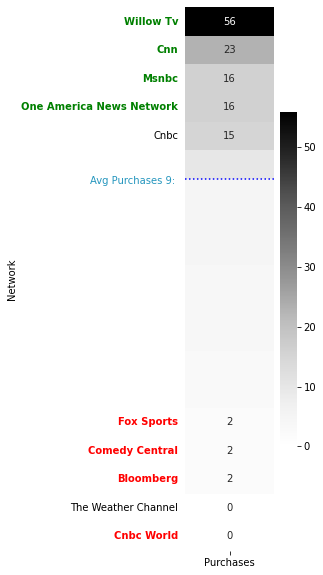

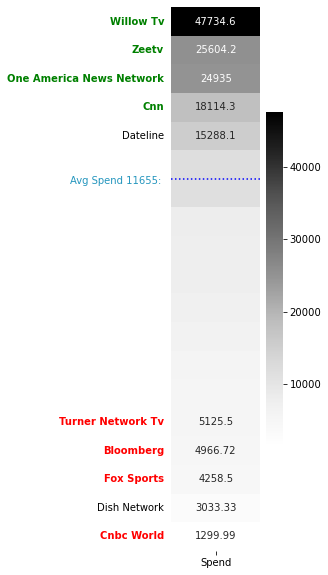

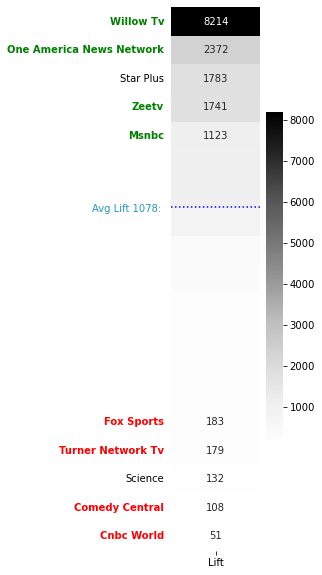

In [5]:
# Top Purchases, Spend, and Lift labels
field1_top_labels = set(report_for_client['Purchases'].sort_values(ascending=False).index.values[0:5])
field2_top_labels = set(report_for_client['Spend'].sort_values(ascending=False).index.values[0:5])
field3_top_labels = set(report_for_client['Lift'].sort_values(ascending=False).index.values[0:5])

## Use set logic to find which channels are in at least 2/3 of the top5 for Purchases, Spend, and Lift
set1 = field1_top_labels.intersection(field2_top_labels)
set2 = field1_top_labels.intersection(field3_top_labels)
set3 = field2_top_labels.intersection(field3_top_labels)
set4 = set1.intersection(set2, set3)
at_least_top_2_of_3_spend_purchase_lift_labels = set1.union(set2, set3, set4)


# Bottom Purchases, Spend, and Lift labels
field1_bottom_labels = set(report_for_client['Purchases'].sort_values(ascending=False).index.values[-5:])
field2_bottom_labels = set(report_for_client['Spend'].sort_values(ascending=False).index.values[-5:])
field3_bottom_labels = set(report_for_client['Lift'].sort_values(ascending=False).index.values[-5:])

## Use set logic to find which channels are in at least 2/3 of the bottom5 for Purchases, Spend, and Lift
set1 = field1_bottom_labels.intersection(field2_bottom_labels)
set2 = field1_bottom_labels.intersection(field3_bottom_labels)
set3 = field2_bottom_labels.intersection(field3_bottom_labels)
set4 = set1.intersection(set2, set3)
at_least_bottom_2_of_3_spend_purchase_lift_labels = set1.union(set2, set3, set4)


make_heatmap(df=report_for_client, 
             field='Purchases', 
             color_map='Greys', 
             top_labels=at_least_top_2_of_3_spend_purchase_lift_labels, 
             bottom_labels=at_least_bottom_2_of_3_spend_purchase_lift_labels)
plt.show()


make_heatmap(df=report_for_client, 
             field='Spend', 
             color_map='Greys', 
             top_labels=at_least_top_2_of_3_spend_purchase_lift_labels, 
             bottom_labels=at_least_bottom_2_of_3_spend_purchase_lift_labels,
             hide_y_label=True)
plt.show()


make_heatmap(df=report_for_client, 
             field='Lift', 
             color_map='Greys', 
             top_labels=at_least_top_2_of_3_spend_purchase_lift_labels, 
             bottom_labels=at_least_bottom_2_of_3_spend_purchase_lift_labels, 
             hide_y_label=True)
plt.show()

#### Purchases and Cost Per Visitor

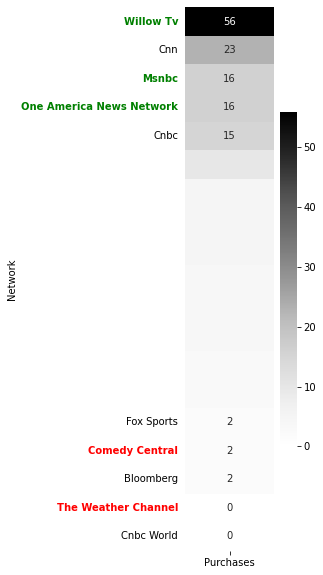

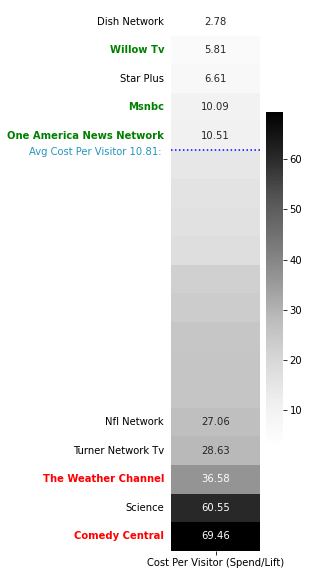

In [6]:
# Use set logic to find which channels are in the top5 for purchases and cost per visitor
top_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[0:5])
top_5_cost_per_visitor=set(report_for_client['Cost Per Visitor (Spend/Lift)'].sort_values(ascending=True).index.values[0:5])

top_5_purchases_and_cost_per_visitor = top_5_purchases.intersection(top_5_cost_per_visitor)

# Use set logic to find which channels are in the bottom5 for purchases and cost per visitor
bottom_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[-5:])
bottom_5_cost_per_visitor=set(report_for_client['Cost Per Visitor (Spend/Lift)'].sort_values(ascending=True).index.values[-5:])

bottom_5_purchases_and_cost_per_visitor = bottom_5_purchases.intersection(bottom_5_cost_per_visitor)



make_heatmap(df=report_for_client, 
             field='Purchases', 
             color_map='Greys', 
             top_labels=top_5_purchases_and_cost_per_visitor, 
             bottom_labels=bottom_5_purchases_and_cost_per_visitor, 
             annotate_horizontal=False)
plt.show()

make_heatmap(df=report_for_client, 
             field='Cost Per Visitor (Spend/Lift)', 
             cutoff_value = overall_cost_per_visitor, 
             asc=True, 
             rounding=".2f",
             top_labels=top_5_purchases_and_cost_per_visitor, 
             bottom_labels=bottom_5_purchases_and_cost_per_visitor, 
             color_map='Greys', 
             hide_y_label=True)
plt.show()

#### Purchases and Cost Per Acquisition

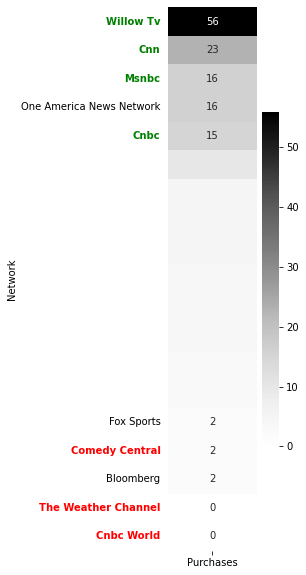

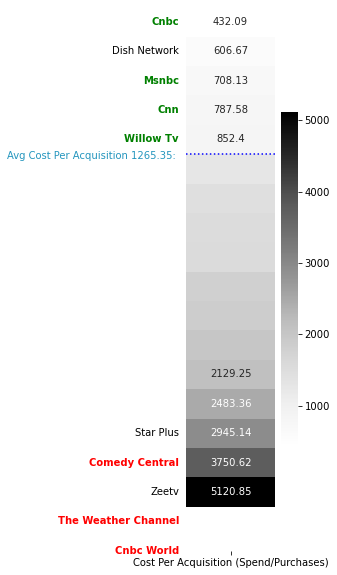

In [7]:
top_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[0:5])
top_5_cost_per_acquisition=set(report_for_client['Cost Per Acquisition (Spend/Purchases)'].sort_values(ascending=True).index.values[0:5])

top_5_purchases_and_cost_per_acquisition = top_5_purchases.intersection(top_5_cost_per_acquisition)


bottom_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[-5:])
bottom_5_cost_per_acquisition=set(report_for_client['Cost Per Acquisition (Spend/Purchases)'].sort_values(ascending=True).index.values[-5:])

bottom_5_purchases_and_cost_per_acquisition = bottom_5_purchases.intersection(bottom_5_cost_per_acquisition)

make_heatmap(df=report_for_client, 
             field='Purchases', 
             color_map='Greys', 
             top_labels=top_5_purchases_and_cost_per_acquisition, 
             bottom_labels=bottom_5_purchases_and_cost_per_acquisition, 
             annotate_horizontal=False)
plt.show()

make_heatmap(df=report_for_client, 
             field='Cost Per Acquisition (Spend/Purchases)', 
             cutoff_value = overall_cost_per_acquisition,
             top_labels = top_5_purchases_and_cost_per_acquisition,
             bottom_labels = bottom_5_purchases_and_cost_per_acquisition,
             asc=True, 
             rounding=".02f",
             color_map='Greys', 
             hide_y_label=True)
plt.show()

#### Purchases and Conversion Rate

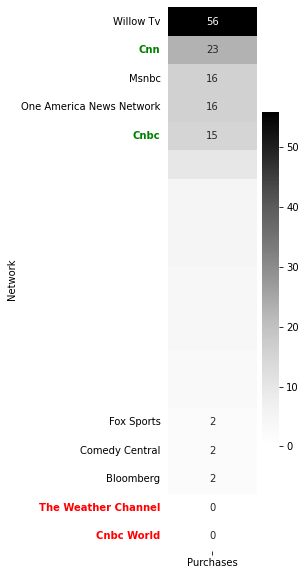

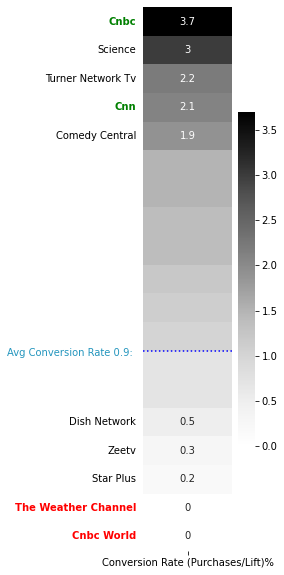

In [8]:
top_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[0:5])
top_5_conversion_rate=set(report_for_client['Conversion Rate (Purchases/Lift)%'].sort_values(ascending=False).index.values[0:5])

top_5_purchases_and_conversion_rate = top_5_purchases.intersection(top_5_conversion_rate)


bottom_5_purchases=set(report_for_client['Purchases'].sort_values(ascending=False).index.values[-5:])
bottom_5_conversion_rate=set(report_for_client['Conversion Rate (Purchases/Lift)%'].sort_values(ascending=False).index.values[-5:])

bottom_5_purchases_and_conversion_rate = bottom_5_purchases.intersection(bottom_5_conversion_rate)

make_heatmap(df=report_for_client, 
             field='Purchases', 
             color_map='Greys', 
             top_labels=top_5_purchases_and_conversion_rate,
             bottom_labels=bottom_5_purchases_and_conversion_rate, 
             annotate_horizontal=False)
plt.show()

make_heatmap(df=report_for_client, 
             field='Conversion Rate (Purchases/Lift)%', 
             cutoff_value = overall_conversion_rate, 
             rounding=".1f",
             top_labels = top_5_purchases_and_conversion_rate,
             bottom_labels = bottom_5_purchases_and_conversion_rate,
             color_map='Greys', 
             hide_y_label=True)
plt.show()

## Scatter Plots

### Plotting Function - make_scatter()

In [9]:
def make_scatter(df, x_field, y_field, x_units='', y_units='', color_1='green', color_2='red'):
    
    from adjustText import adjust_text
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # ax.tick_params(top=False,
    #                bottom=True,
    #                left=True,
    #                right=False,
    #                labelleft=False,
    #                labelbottom=False)
    
    df[x_field] = df[x_field].replace(np.inf, 0)
    df[y_field] = df[y_field].replace(np.inf, 0)
    
    df.plot(kind='scatter', x=x_field, y=y_field, ax=ax)
    
    x_field_mean = df[x_field].mean()
    y_field_mean = df[y_field].mean()
    
    if x_units == "$":
        x_field_mean = round(x_field_mean, 2)
    elif x_units == "%":
        x_field_mean = round(x_field_mean, 1)
    else:
        x_field_mean = round(x_field_mean)
        
    if y_units == "$":
        y_field_mean = round(y_field_mean, 2)
    elif y_units == "%":
        y_field_mean = round(y_field_mean, 1)
    else:
        y_field_mean = round(y_field_mean)

    
    low_x_high_y = df[(df[x_field] < x_field_mean) & (df[y_field] >= y_field_mean)]
    high_x_low_y = df[(df[x_field] >= x_field_mean) & (df[y_field] < y_field_mean)]

    together = []
    
    for i in range(len(low_x_high_y)):
        txt1 = low_x_high_y.index[i]
        x_coord1 = low_x_high_y[x_field][i]
        y_coord1 = low_x_high_y[y_field][i]
        #size1 = low_x_high_y['Purchases'][i]
        color1 = color_1
        together.append((txt1, x_coord1, y_coord1, color1))
        ax.scatter(x_coord1, y_coord1, color=color1)

    for i in range(len(high_x_low_y)):
        txt2 = high_x_low_y.index[i]
        x_coord2 = high_x_low_y[x_field][i]
        y_coord2 = high_x_low_y[y_field][i]
        color2 = color_2
        together.append((txt2, x_coord2, y_coord2, color2))
        ax.scatter(x_coord2, y_coord2, color=color2)
    together.sort()


    text = [x for (x,y,z,c) in together]
    x_coords = [y for (x,y,z,c) in together]
    y_coords = [z for (x,y,z,c) in together]
    colors = [c for (x,y,z,c) in together]

    texts = []
    for x, y, s, c in zip(x_coords, y_coords, text, colors):
        texts.append(plt.text(x, y, s, color=c))

    
    # I should lookup how to do this with regex to make things easier...
    x_annot_text = x_field
    y_annot_text = y_field
    if x_field == "Conversion Rate (Purchases/Lift)%":
        x_annot_text = "Conversion Rate"
    elif x_field == "Cost Per Acquisition (Spend/Purchases)":
        x_annot_text = "Cost Per Acquisition"
    elif x_field == "Cost Per Visitor (Spend/Lift)":
        x_annot_text = "Cost Per Visitor"
        
    if y_field == "Conversion Rate (Purchases/Lift)%":
        y_annot_text = "Conversion Rate"
    elif y_field == "Cost Per Acquisition (Spend/Purchases)":
        y_annot_text = "Cost Per Acquisition"
    elif y_field == "Cost Per Visitor (Spend/Lift)":
        y_annot_text = "Cost Per Visitor"
    
    
    
    plt.axvline(x=x_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean {x_annot_text}'#: {round(x_field_mean, 2)}{x_units}'
                ,
                xy=(x_field_mean, max(ax.get_ylim())), xycoords='data',
                xytext=(0, 2), textcoords='offset pixels',
                color='k', ha='center')
    
    plt.axhline(y=y_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean\n{y_annot_text}' #:\n{round(y_field_mean, 2)}{y_units}'
                ,
                xy=(max(ax.get_xlim()), y_field_mean), xycoords='data',
                xytext=(5, 0), textcoords='offset pixels',
                color='k', ha='left')
    
    ax.axes.set_xticks([0, x_field_mean])
    #ax.axes.xaxis.set_ticklabels([])
    ax.axes.set_yticks([0, y_field_mean])
    #ax.axes.yaxis.set_ticklabels([])
    
    adjust_text(texts, 
            force_text=(1,1),
            force_points=(1,1),
            force_objects=(1,1),
            only_move={'points':'y', 'texts':'y'},
            arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

    return fig, ax;

In [10]:
def make_scatter_with_size_adjustment(df,
                  x_field,
                  y_field,
                  size_scale,
                  x_units='',
                  y_units='',
                  color_1='green',
                  color_2='red',
                  expand_text=(1.5, 1.5),
                  expand_points=(3,3),
                  expand_objects=(3,3),
                  force_text=(1,1),
                  force_points=(1,1),
                  force_objects=(1,1),
                  annotate_text=True):
    
    from adjustText import adjust_text
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # ax.tick_params(top=False,
    #                bottom=True,
    #                left=True,
    #                right=False,
    #                labelleft=False,
    #                labelbottom=False)
    
    df[x_field] = df[x_field].replace(np.inf, 0)
    df[y_field] = df[y_field].replace(np.inf, 0)
    
    df.plot(kind='scatter', x=x_field, y=y_field, ax=ax)
    
    x_field_mean = df[x_field].mean()
    y_field_mean = df[y_field].mean()
    
    if x_units == "$":
        x_field_mean = round(x_field_mean, 2)
    elif x_units == "%":
        x_field_mean = round(x_field_mean, 1)
    else:
        x_field_mean = round(x_field_mean)
        
    if y_units == "$":
        y_field_mean = round(y_field_mean, 2)
    elif y_units == "%":
        y_field_mean = round(y_field_mean, 1)
    else:
        y_field_mean = round(y_field_mean)

    
    low_x_high_y = df[(df[x_field] < x_field_mean) & (df[y_field] >= y_field_mean)]
    high_x_low_y = df[(df[x_field] >= x_field_mean) & (df[y_field] < y_field_mean)]

    together = []
    
    for i in range(len(low_x_high_y)):
        txt1 = low_x_high_y.index[i]
        x_coord1 = low_x_high_y[x_field][i]
        y_coord1 = low_x_high_y[y_field][i]
        size1 = low_x_high_y['Purchases'][i]
        if size1 == 0:
            size1 = size_scale * 1 / size_scale
        color1 = color_1
        together.append((txt1, x_coord1, y_coord1, color1))
        ax.scatter(x_coord1, y_coord1, color=color1, s=size1*size_scale)

    for i in range(len(high_x_low_y)):
        txt2 = high_x_low_y.index[i]
        x_coord2 = high_x_low_y[x_field][i]
        y_coord2 = high_x_low_y[y_field][i]
        size2 = high_x_low_y['Purchases'][i]
        if size2 == 0:
            size2 = size_scale * 1 / size_scale
        color2 = color_2
        together.append((txt2, x_coord2, y_coord2, color2))
        ax.scatter(x_coord2, y_coord2, color=color2, s=size2*size_scale)
    together.sort()


    text = [x for (x,y,z,c) in together]
    x_coords = [y for (x,y,z,c) in together]
    y_coords = [z for (x,y,z,c) in together]
    colors = [c for (x,y,z,c) in together]
    
    if annotate_text==True:
        texts = []
        for x, y, s, c in zip(x_coords, y_coords, text, colors):
            texts.append(plt.text(x, y, s, color=c))

    
    # I should lookup how to do this with regex to make things easier...
    x_annot_text = x_field
    y_annot_text = y_field
    if x_field == "Conversion Rate (Purchases/Lift)%":
        x_annot_text = "Conversion Rate"
    elif x_field == "Cost Per Acquisition (Spend/Purchases)":
        x_annot_text = "Cost Per Acquisition"
    elif x_field == "Cost Per Visitor (Spend/Lift)":
        x_annot_text = "Cost Per Visitor"
        
    if y_field == "Conversion Rate (Purchases/Lift)%":
        y_annot_text = "Conversion Rate"
    elif y_field == "Cost Per Acquisition (Spend/Purchases)":
        y_annot_text = "Cost Per Acquisition"
    elif y_field == "Cost Per Visitor (Spend/Lift)":
        y_annot_text = "Cost Per Visitor"
    
    
    
    plt.axvline(x=x_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean {x_annot_text}'#: {round(x_field_mean, 2)}{x_units}'
                ,
                xy=(x_field_mean, max(ax.get_ylim())), xycoords='data',
                xytext=(0, 2), textcoords='offset pixels',
                color='k', ha='center')
    
    plt.axhline(y=y_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean\n{y_annot_text}' #:\n{round(y_field_mean, 2)}{y_units}'
                ,
                xy=(max(ax.get_xlim()), y_field_mean), xycoords='data',
                xytext=(5, 0), textcoords='offset pixels',
                color='k', ha='left')
    
    ax.axes.set_xticks([0, x_field_mean])
    #ax.axes.xaxis.set_ticklabels([])
    ax.axes.set_yticks([0, y_field_mean])
    #ax.axes.yaxis.set_ticklabels([])
    
    if annotate_text == True:
        adjust_text(texts,
                expand_text=expand_text,
                expand_points=expand_points,
                expand_objects=expand_objects,
                force_text=force_text,
                force_points=force_points,
                force_objects=force_objects,
                only_move={'points':'y', 'texts':'y'},
                arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

    return fig, ax;

#### Spend vs. Purchases

In [11]:
scale=10

In [12]:
willow_tv = report_for_client.query("`Network` == 'Willow Tv'")
willow_tv_purchases = willow_tv['Purchases']
willow_tv_spend = willow_tv['Spend']
willow_tv_lift = willow_tv['Lift']

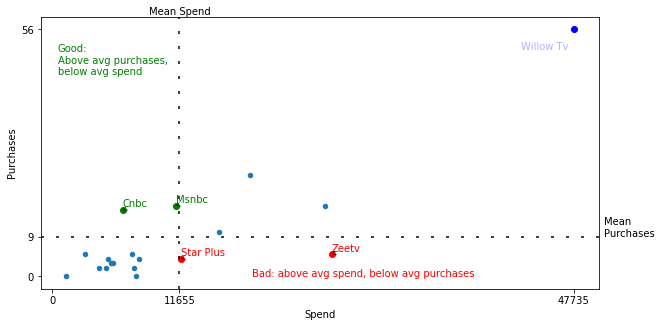

In [13]:
fig, ax = make_scatter(df=report_for_client,
                       x_field='Spend',
                       y_field='Purchases', 
                       #size=False,
                       x_units='$', 
                       y_units='', 
                       color_1='green',
                       color_2='red')
ax.scatter(willow_tv_spend, willow_tv_purchases, c='blue')
text1 = ax.annotate(text='Willow Tv',
            xy=(willow_tv_spend, willow_tv_purchases),
            xytext=(-5, -20), textcoords='offset pixels',
            ha='right',
            color='blue',
            alpha=0.3)
# import matplotlib.patheffects as pe
# text1.set_path_effects(path_effects=[pe.withStroke(linewidth=2, foreground='black'), pe.Normal()])

# Label x and y values of outlier on xticks and yticks
current_xticks = ax.get_xticks()
updated_xticks = np.append(current_xticks, willow_tv['Spend'])
ax.set_xticks(updated_xticks)

current_yticks = ax.get_yticks()
updated_yticks = np.append(current_yticks, willow_tv['Purchases'])
ax.set_yticks(updated_yticks)

plt.annotate("Good:\nAbove avg purchases,\nbelow avg spend", xy=(0.08, 0.7), xycoords="figure fraction", c='g')
plt.annotate("Bad: above avg spend, below avg purchases", xy=(0.35, 0.14), xycoords="figure fraction", c='r')

plt.show()

#### Lift vs. Purchases

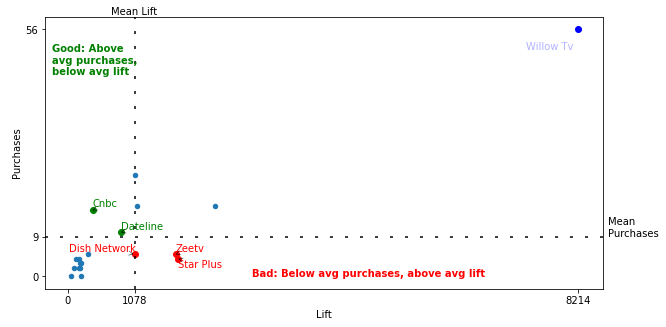

In [14]:
fig, ax = make_scatter(report_for_client,
                       x_field='Lift',
                       y_field='Purchases',
                       x_units='',
                       y_units='')

ax.scatter(willow_tv_lift, willow_tv_purchases, c='blue')
text1 = ax.annotate(text='Willow Tv',
            xy=(willow_tv_lift, willow_tv_purchases),
            xytext=(-5, -20), textcoords='offset pixels',
            ha='right',
            color='blue',
            alpha=0.3)

# Label x and y values of outlier on xticks and yticks
current_xticks = ax.get_xticks()
updated_xticks = np.append(current_xticks, willow_tv['Lift'])
ax.set_xticks(updated_xticks)

current_yticks = ax.get_yticks()
updated_yticks = np.append(current_yticks, willow_tv['Purchases'])
ax.set_yticks(updated_yticks)

plt.annotate("Good: Above\navg purchases,\nbelow avg lift", xy=(0.072, 0.7), xycoords="figure fraction", c='g', weight='bold')
plt.annotate("Bad: Below avg purchases, above avg lift", xy=(0.35, 0.14), xycoords="figure fraction", c='r', weight='bold')

plt.show()

#### Spend vs. Lift

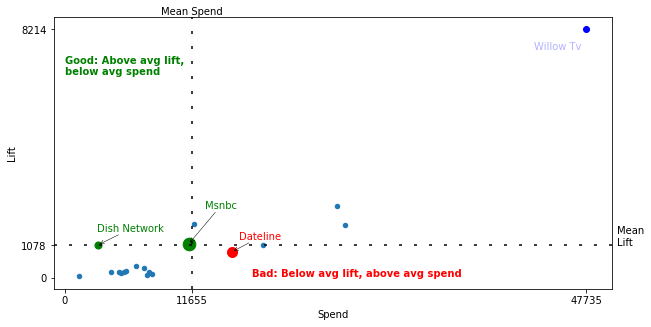

In [15]:
fig, ax = make_scatter_with_size_adjustment(report_for_client,
                                            x_field='Spend',
                                            y_field='Lift',
                                            size_scale=scale,
                                            x_units='',
                                            y_units='$',
                                            color_1='green',
                                            color_2='red')
ax.scatter(willow_tv_spend, willow_tv_lift, c='blue')
text1 = ax.annotate(text='Willow Tv',
            xy=(willow_tv_spend, willow_tv_lift),
            xytext=(-5, -20), textcoords='offset pixels',
            ha='right',
            color='blue',
            alpha=0.3)

current_xticks = ax.get_xticks()
updated_xticks = np.append(current_xticks, willow_tv['Spend'])
ax.set_xticks(updated_xticks)

current_yticks = ax.get_yticks()
updated_yticks = np.append(current_yticks, willow_tv['Lift'])
ax.set_yticks(updated_yticks)

plt.annotate("Good: Above avg lift,\nbelow avg spend", xy=(0.09, 0.7), xycoords="figure fraction", c='g', weight='bold')
plt.annotate("Bad: Below avg lift, above avg spend", xy=(0.35, 0.14), xycoords="figure fraction", c='r', weight='bold')

plt.show()

#### Spend vs. Conversion Rate

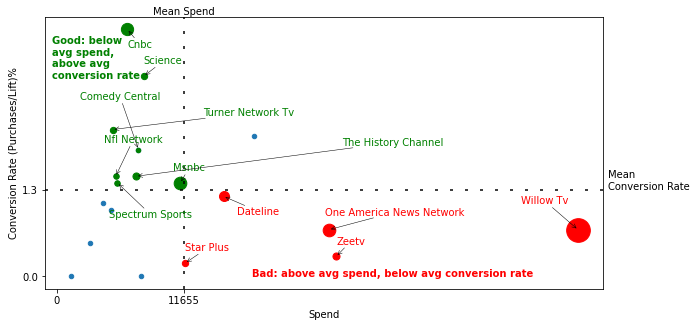

In [16]:
make_scatter_with_size_adjustment(report_for_client,
             x_field='Spend',
             y_field='Conversion Rate (Purchases/Lift)%',
             size_scale=scale,
             x_units='$',
             y_units='%',
             color_1='green',
             color_2='red',
             annotate_text=True)

plt.annotate("Good: below\navg spend,\nabove avg\nconversion rate", xy=(0.072, 0.69), xycoords="figure fraction", c='g', weight='bold')
plt.annotate("Bad: above avg spend, below avg conversion rate", xy=(0.35, 0.14), xycoords="figure fraction", c='r', weight='bold')

plt.show();

#### Conversion Rate vs. Cost Per Acquisition

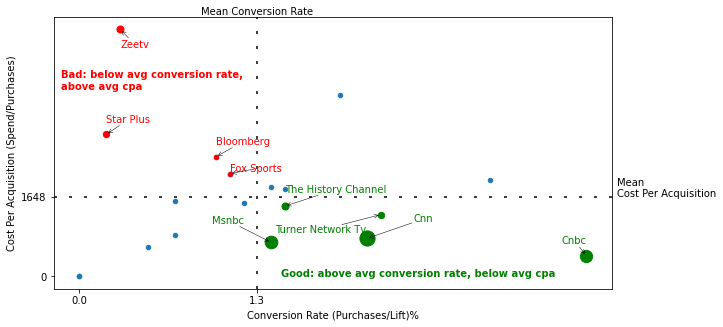

In [17]:
make_scatter_with_size_adjustment(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Cost Per Acquisition (Spend/Purchases)',
             size_scale=scale,
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

plt.annotate("Bad: below avg conversion rate,\nabove avg cpa", xy=(0.085, 0.66), xycoords="figure fraction", c='r', weight='bold')
plt.annotate("Good: above avg conversion rate, below avg cpa", xy=(0.39, 0.14), xycoords="figure fraction", c='g', weight='bold')

plt.show();

#### Conversion Rate vs. Cost Per Visitor

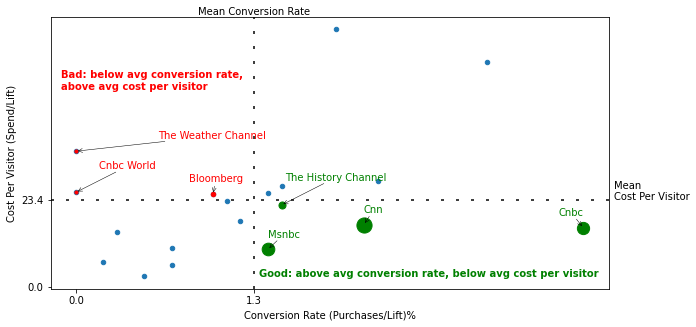

In [18]:
make_scatter_with_size_adjustment(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Visitor (Spend/Lift)",
             size_scale=scale,
             x_units="%",
             y_units="$",
             color_1='red',
             color_2='green')

plt.annotate("Bad: below avg conversion rate,\nabove avg cost per visitor", xy=(0.085, 0.66), xycoords="figure fraction", c='r', weight='bold')
plt.annotate("Good: above avg conversion rate, below avg cost per visitor", xy=(0.36, 0.14), xycoords="figure fraction", c='g', weight='bold')

plt.show();

In [19]:
report_for_client["Cost Per Visitor (Spend/Lift)"].mean()

23.388947368421054

## Bar Charts

### Channels with no spend, but had purchases.  Excluding 'Other' and '(Blank)'

In [20]:
no_spend_but_purchases = channels_no_spend.query("Purchases > 0 & `Network` != 'Other' & `Network` != '(Blank)'").copy(deep=True)

In [21]:
no_spend_but_purchases

,Purchases
Network,
Fox News,14.0
Aapka Colors,6.0
Hgtv,6.0
Television Food Network,4.0
Sony Entertainment Tv,4.0
Espn,4.0
Fyi,2.0
Diy,2.0
Oprah Winfrey Network,1.0


In [22]:
no_spend_but_purchases['percent_of_all_purchases'] = no_spend_but_purchases['Purchases'] / total_purchases_from_campaign * 100

In [23]:
num_networks = len(report_for_client.index.values) + len(channels_no_spend.index.values)

mean_num_purchases_with_spend = round(report_for_client['Purchases'].mean(), 0)
mean_num_purchases_from_campaign = round(total_purchases_from_campaign / num_networks, 0)

In [24]:
no_spend_but_above_mean_purchases_from_campaign_labels = no_spend_but_purchases[no_spend_but_purchases['Purchases'] > mean_num_purchases_from_campaign].index.values

In [25]:
# no_spend_but_purchases['above_mean_purchases_from_campaign'] = no_spend_but_purchases['Purchases'] > mean_num_purchases_from_campaign

In [26]:
no_spend_yticks = []
for label in no_spend_but_purchases.index.values:
    if label in no_spend_but_above_mean_purchases_from_campaign_labels:
        no_spend_yticks.append(label)
    else:
        no_spend_yticks.append('')

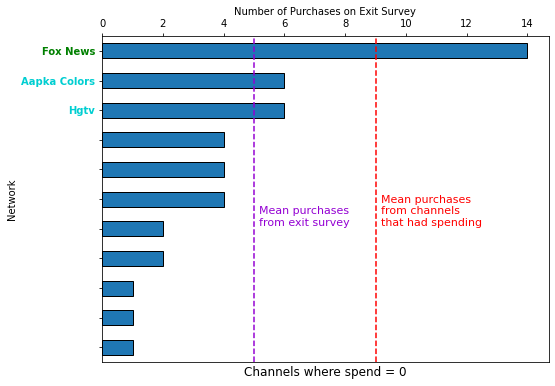

In [34]:
import matplotlib.patheffects as pe

fig, ax = plt.subplots(1,1,figsize=(8,6))
no_spend_but_purchases['Purchases'].plot(kind='barh', ax=ax, edgecolor='black')
ax.set_xlabel('Number of Purchases on Exit Survey')
ax.set_title('Channels where spend = 0', y=-0.06)


ax.axvline(mean_num_purchases_with_spend, color='red', linestyle='--')
text1 = ax.annotate(F'Mean purchases\nfrom channels\nthat had spending',
                xy=(mean_num_purchases_with_spend, 0), xycoords='data',
                xytext=(5, -175), textcoords='offset pixels', size=11,
                color='red', ha='left')
# text1.set_path_effects(path_effects=[pe.withStroke(linewidth=2.5, foreground='black'), pe.Normal()])

ax.axvline(mean_num_purchases_from_campaign, color='darkviolet', linestyle='--')
text2 = ax.annotate(F'Mean purchases\nfrom exit survey',
                xy=(mean_num_purchases_from_campaign, 0), xycoords='data',
                xytext=(5, -175), textcoords='offset pixels', size=11,
                color='darkviolet', ha='left')
# text2.set_path_effects(path_effects=[pe.withStroke(linewidth=1.3, foreground='black'), pe.Normal()])

ax.set_yticklabels(no_spend_yticks)

yticks=plt.gca().get_yticklabels()



for text in yticks:
    if text.get_text() == 'Fox News':
        text.set_weight('bold')
        text.set_color('green')
    elif text.get_text() == 'Aapka Colors' or text.get_text() == 'Hgtv':
        text.set_weight('bold')
        text.set_color('darkturquoise')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis();

# Finish